In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from typing import Dict, Tuple
import pymongo

In [2]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv

load_dotenv()

mongo_url = os.getenv("MONGO_URL")
if not mongo_url:
    raise ValueError("MONGO_URL not set in .env")

client = MongoClient(mongo_url, serverSelectionTimeoutMS=5000)  # 5-second timeout
db = client["storage_simulation"]
collection = db["usage_logs"]

# Optional: test the connection
try:
    client.admin.command('ping')
    print("MongoDB connection successful")
except Exception as e:
    print(f"MongoDB connection failed: {e}")

MongoDB connection successful


In [3]:
# Configuration
# here we we use 4 hour aggrigation so 7 per day
tf.keras.mixed_precision.set_global_policy('mixed_float16')
HORIZONS = {   
    '1_month': 180,   # 30 days (6*30=180)  
}
SEQ_LENGTH = 42  # 7 days of historical data
BATCH_SIZE = 256
EPOCHS = 50

In [4]:
def load_and_preprocess_data() -> Dict[str, dict]:
    """Load and preprocess data with proper feature engineering"""
    raw_data = pd.DataFrame(list(collection.find()))
    raw_data = raw_data.drop(columns=['_id'])
    raw_data['timestamp'] = pd.to_datetime(raw_data['timestamp'])

    print("\n🔍 Data Diagnostics:")
    print(f"Total records: {len(raw_data)}")
    print("Unique directories:", raw_data['directory'].unique())

    processed = {}
    for directory in raw_data['directory'].unique():
        df = raw_data[raw_data['directory'] == directory].copy()
        df = df.sort_values('timestamp').set_index('timestamp')

        # Resample to 4-hour intervals
        # The 'directory' column is excluded from the mean calculation
        df = df[['storage_gb']].resample('4h').mean().ffill()

        # Feature engineering
        df['hour'] = df.index.hour
        df['time_sin'] = np.sin(2 * np.pi * df.index.hour/23)
        df['time_cos'] = np.cos(2 * np.pi * df.index.hour/23)

        # Scale storage_gb
        scaler = MinMaxScaler()
        df['scaled_gb'] = scaler.fit_transform(df[['storage_gb']])

        processed[directory] = {
            'data': df[['scaled_gb', 'time_sin', 'time_cos']],
            'original': df['storage_gb'],
            'scaler': scaler
        }

    return processed

In [5]:
def create_sequences(features: np.ndarray, targets: np.ndarray,
                    seq_length: int, horizon: int) -> Tuple[np.ndarray, np.ndarray]:
    """Create sequences with validation"""
    X, y = [], []
    max_start = len(features) - seq_length - horizon
    if max_start < 0:
        return np.array([]), np.array([])

    for i in range(max_start + 1):
        X.append(features[i:i+seq_length])
        y.append(targets[i+seq_length:i+seq_length+horizon])
    return np.array(X), np.array(y)

In [6]:
#model
def build_model(input_shape: Tuple[int, int], output_steps: int) -> Model:
    """Optimized forecasting model architecture"""
    inputs = Input(shape=input_shape)

    # Temporal pattern extraction
    x = Conv1D(64, 3, activation='relu', padding='causal')(inputs)
    x = GRU(128, return_sequences=True)(x)
    x = GRU(64)(x)

    # Prediction head
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_steps)(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
    return model

In [7]:
import os
import joblib

def save_model_and_scaler(model, scaler, name):
    notebooks_dir = os.getcwd()

    # Ensure name is only a base name, not a path
    safe_name = os.path.basename(name)
    safe_name = safe_name.replace('/', '_').replace('\\', '_')

    # Create models directory
    models_dir = os.path.join(notebooks_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Final model path
    model_path = os.path.join(models_dir, f"{safe_name}_monthly_forecast_model.keras")
    model.save(model_path)
    print(f"Model saved at: {model_path}")

    # Create scalers directory
    scalers_dir = os.path.join(notebooks_dir, 'scalers')
    os.makedirs(scalers_dir, exist_ok=True)

    # Final scaler path
    scaler_path = os.path.join(scalers_dir, f"{safe_name}_monthly_scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print(f"Scaler saved at: {scaler_path}")

In [8]:
def train_and_evaluate(data_dict: Dict) -> Tuple[Dict, Dict, Dict]:
    """Enhanced training with proper validation"""
    modeles = {}
    metrics = {}

    for name, data in data_dict.items():
        print(f"\n⚡ Processing {name}")
        df = data['data']
        scaler = data['scaler']

        # Prepare data
        total_points = len(df)
        test_size = HORIZONS['1_month'] + SEQ_LENGTH
        split_idx = total_points - test_size

        if split_idx < SEQ_LENGTH:
            print(f"⚠️ Insufficient data for {name}")
            continue

        # Create sequences
        X_train, y_train = create_sequences(
            df.values[:split_idx],
            df['scaled_gb'].values[:split_idx],
            SEQ_LENGTH, HORIZONS['1_month']
        )
        X_test, y_test = create_sequences(
            df.values[split_idx:],
            df['scaled_gb'].values[split_idx:],
            SEQ_LENGTH, HORIZONS['1_month']
        )

        if len(X_train) == 0 or len(X_test) == 0:
            print(f"🚫 Sequence creation failed for {name}")
            continue

        # Model setup
        model = build_model((SEQ_LENGTH, 3), HORIZONS['1_month'])
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[
                EarlyStopping(patience=7, restore_best_weights=True),
                ModelCheckpoint(f'best_{name}.keras', save_best_only=True)
            ],
            verbose=1
        )

        # Generate predictions
        test_pred = model.predict(X_test)
        metrics[name] = {}

        # Calculate metrics for each horizon
        for horizon_name, steps in HORIZONS.items():
            preds = test_pred[:, :steps].reshape(-1, 1)
            true = y_test[:, :steps].reshape(-1, 1)

            # Inverse transform predictions
            preds_gb = scaler.inverse_transform(preds).reshape(-1, steps)
            true_gb = scaler.inverse_transform(true).reshape(-1, steps)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(true_gb, preds_gb))

            metrics[name][horizon_name] = {
                'rmse': rmse,
                'predictions': preds_gb[0],
                'true': true_gb[0]
            }

        modeles[name] = model
        save_model_and_scaler(model, scaler, name)

    return modeles, metrics

In [9]:
def plot_results(name: str, data: dict, metrics: dict):
    """Enhanced plotting with actual dates"""
    if name not in metrics:
        return

    plt.figure(figsize=(14, 7))
    original = data['original']

    # Get test period dates
    test_dates = original.index[-HORIZONS['1_month']:]

    for horizon in HORIZONS:
        if horizon not in metrics[name]:
            continue

        steps = HORIZONS[horizon]
        preds = metrics[name][horizon]['predictions'][:steps]
        true = metrics[name][horizon]['true'][:steps]
        dates = test_dates[:steps]

        plt.plot(dates, preds, label=f'{horizon} forecast')
        plt.fill_between(dates,
                        preds * 0.95,
                        preds * 1.05,
                        alpha=0.1)
        plt.plot(dates, true, '--', label='Actual')

    plt.title(f'{name} Storage Forecast')
    plt.ylabel('Storage (GB)')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


🔍 Data Diagnostics:
Total records: 292620
Unique directories: ['/scratch' '/projects' '/customer' '/info']



⚡ Processing /scratch
Epoch 1/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - loss: 0.2433

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.2490

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.2528

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.2529

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.2526

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.2519

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.2501

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.2479

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.2454

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.2429

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.2403

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.2376

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2348

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.2320

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2292

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.2264

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.2239

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - loss: 0.2217 - val_loss: 0.0764


Epoch 2/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 0.0876

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0852

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0838

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0822

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0806

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0791

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0775

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0761

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0747

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0734

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - loss: 0.0721

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0709

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0698

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0687

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0677

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0668

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0659

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.0652 - val_loss: 0.0103


Epoch 3/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - loss: 0.0315

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0326

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0330

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0331

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0330

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0328

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0327

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0326

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0325

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0323

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0322

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0320

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0319

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0317

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0315

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0314

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0313

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0311 - val_loss: 0.0020


Epoch 4/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - loss: 0.0235

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0239

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0242

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0242

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0242

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0242

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0242

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.0242

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0242

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - loss: 0.0242

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0242

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0242

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0242

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0242

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0242

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0241

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0241

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.0241 - val_loss: 0.0021


Epoch 5/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0196

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0202

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 0.0206

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 0.0210

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.0212

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0214

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0215

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0216

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0216

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0216

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0216

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0216

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0216

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0215

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0215

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0215

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0215

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - loss: 0.0214 - val_loss: 0.0027


Epoch 6/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - loss: 0.0200

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0197

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0195

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0196

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0196

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0196

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0196

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0197

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0197

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0197

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - loss: 0.0196

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0196

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - loss: 0.0196

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.0196

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - loss: 0.0196

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0196

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0196

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - loss: 0.0196 - val_loss: 0.0013


Epoch 7/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step - loss: 0.0196

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - loss: 0.0197

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 330ms/step - loss: 0.0197

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.0195

 5/17 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step - loss: 0.0194

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.0194

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step - loss: 0.0194

 8/17 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.0194

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - loss: 0.0194

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - loss: 0.0194

11/17 ━━━━━━━━━━━━━━━━━━━━ 2s 347ms/step - loss: 0.0194

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 351ms/step - loss: 0.0194

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - loss: 0.0194

14/17 ━━━━━━━━━━━━━━━━━━━━ 1s 354ms/step - loss: 0.0194

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.0193

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - loss: 0.0193

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - loss: 0.0193

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 344ms/step - loss: 0.0193 - val_loss: 0.0021


Epoch 8/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - loss: 0.0189

 2/17 ━━━━━━━━━━━━━━━━━━━━ 5s 378ms/step - loss: 0.0191

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - loss: 0.0193

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 302ms/step - loss: 0.0192

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - loss: 0.0190

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.0189

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0188

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 0.0187

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.0187

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.0186

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step - loss: 0.0186

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0185

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - loss: 0.0185

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0185

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0185

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0184

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0184

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0184 - val_loss: 0.0028


Epoch 9/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0178

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0182

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0181

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0180

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0179

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0178

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - loss: 0.0178

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - loss: 0.0177

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 282ms/step - loss: 0.0177

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.0177

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0178

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - loss: 0.0178

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.0178

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - loss: 0.0178

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0179

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0179

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0179

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0179 - val_loss: 0.0043


Epoch 10/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - loss: 0.0176

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0174

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0174

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0175

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0175

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0175

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0175

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0174

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0174

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0174

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0174

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0175

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0175

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0174

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0174

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0174

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0174

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0174 - val_loss: 0.0026


Epoch 11/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - loss: 0.0167

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0169

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0167

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0166

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0166

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0167

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0167

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0167

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - loss: 0.0168

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0168

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0168

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0168

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0168

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0168

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0168

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.0168 - val_loss: 0.0012


Epoch 12/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - loss: 0.0159

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 0.0160

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0163

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0163

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0163

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0164

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0164

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0164

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0164

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0164

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0164

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0164

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0164

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0165

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0165

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0165

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.0165

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0165 - val_loss: 0.0021


Epoch 13/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0161

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - loss: 0.0161

 3/17 ━━━━━━━━━━━━━━━━━━━━ 5s 357ms/step - loss: 0.0161

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 0.0161

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - loss: 0.0161

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0161

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0161

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - loss: 0.0162

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0162

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - loss: 0.0162

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0162

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - loss: 0.0163

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0163

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.0163

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0163

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0163

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0163

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 0.0163 - val_loss: 0.0040


Epoch 14/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - loss: 0.0167

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 325ms/step - loss: 0.0168

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - loss: 0.0168

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 0.0168

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 0.0168

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.0169

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 0.0169

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.0169

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.0169

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - loss: 0.0169

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.0169

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.0169

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - loss: 0.0168

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0168

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0168

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 297ms/step - loss: 0.0168 - val_loss: 0.0016


Epoch 15/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - loss: 0.0156

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - loss: 0.0158

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 331ms/step - loss: 0.0160

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - loss: 0.0160

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 333ms/step - loss: 0.0160

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - loss: 0.0159

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - loss: 0.0159

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 327ms/step - loss: 0.0159

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step - loss: 0.0159

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.0159

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - loss: 0.0159

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - loss: 0.0159

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 0.0159

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0159

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - loss: 0.0158

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - loss: 0.0158

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0158

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - loss: 0.0158 - val_loss: 0.0013


Epoch 16/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0160

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0157

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0156

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0156

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0156

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0156

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0156

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.0156

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0157

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0157

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0157

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0157

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0157

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0157

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0157

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0157

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0157

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0157 - val_loss: 9.9314e-04


Epoch 17/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - loss: 0.0147

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 252ms/step - loss: 0.0152

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 247ms/step - loss: 0.0153

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0153

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 256ms/step - loss: 0.0154

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0154

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0154

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0155

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - loss: 0.0155

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0156

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0156

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - loss: 0.0157

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - loss: 0.0157

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0157

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0157

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - loss: 0.0157

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0158

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - loss: 0.0158 - val_loss: 0.0010


Epoch 18/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0162

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0166

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0164

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0163

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.0163

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.0163

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0163

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0162

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0162

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0162

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - loss: 0.0162

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0162

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0162

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0162

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0162

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0161

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0161

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0161 - val_loss: 0.0015


Epoch 19/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.0152

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 0.0154

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 0.0154

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - loss: 0.0154

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0154

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.0155

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0155

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0155

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0155

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0155

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0155

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0156

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0156

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0156

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - loss: 0.0156

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0156

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0156

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - loss: 0.0156 - val_loss: 0.0019


Epoch 20/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - loss: 0.0150

 2/17 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step - loss: 0.0146

 3/17 ━━━━━━━━━━━━━━━━━━━━ 5s 400ms/step - loss: 0.0148

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - loss: 0.0149

 5/17 ━━━━━━━━━━━━━━━━━━━━ 4s 343ms/step - loss: 0.0150

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.0150

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 316ms/step - loss: 0.0151

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 0.0152

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - loss: 0.0153

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - loss: 0.0153

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 309ms/step - loss: 0.0153

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - loss: 0.0153

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - loss: 0.0153

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0153

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 0.0153

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.0153

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0153

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.0153 - val_loss: 0.0054


Epoch 21/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - loss: 0.0140

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0150

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - loss: 0.0153

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.0153

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - loss: 0.0154

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - loss: 0.0155

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0156

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - loss: 0.0157

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 0.0158

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0159

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - loss: 0.0159

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0159

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0160

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0160

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0160

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0160

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0160

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - loss: 0.0160 - val_loss: 0.0041


Epoch 22/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.0173

 2/17 ━━━━━━━━━━━━━━━━━━━━ 5s 355ms/step - loss: 0.0167

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 321ms/step - loss: 0.0163

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0161

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.0161

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.0160

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - loss: 0.0159

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0159

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0158

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - loss: 0.0157

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.0157

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.0157

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0156

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - loss: 0.0156

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - loss: 0.0156

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 0.0156

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0155

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 0.0155 - val_loss: 0.0011


Epoch 23/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 347ms/step - loss: 0.0153

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - loss: 0.0151

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - loss: 0.0151

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - loss: 0.0152

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 314ms/step - loss: 0.0152

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 312ms/step - loss: 0.0152

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - loss: 0.0153

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 0.0153

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0154

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - loss: 0.0154

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step - loss: 0.0154

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - loss: 0.0154

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - loss: 0.0154

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - loss: 0.0154

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0154

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0154

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 0.0154

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 308ms/step - loss: 0.0154 - val_loss: 0.0017


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Model saved at: D:\Projects\HPE-StoragePrediction\notebooks\models\scratch_monthly_forecast_model.keras
Scaler saved at: D:\Projects\HPE-StoragePrediction\notebooks\scalers\scratch_monthly_scaler.pkl

⚡ Processing /projects


Epoch 1/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 1:01 4s/step - loss: 0.3255

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.3321

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.3288

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.3228

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - loss: 0.3180

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.3129

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.3081

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.3039

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.2996

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.2953

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.2911

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.2870

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.2829

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.2789

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.2750

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.2711

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.2676

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 246ms/step - loss: 0.2645 - val_loss: 0.1517


Epoch 2/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0782

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.0792

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0782

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0767

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0750

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0733

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0716

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0700

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0686

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0674

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0662

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0651

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0641

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0631

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0621

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0612

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0604

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0597 - val_loss: 0.0216


Epoch 3/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 0.0285

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.0278

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0273

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0271

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0270

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0268

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0266

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0264

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0262

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0260

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0258

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0257

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0255

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0253

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0252

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0250

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0249

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 0.0248 - val_loss: 0.0074


Epoch 4/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0162

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0164

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0167

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0168

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.0170

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.0171

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.0171

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - loss: 0.0171

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0171

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - loss: 0.0171

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0171

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0171

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0171

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0170

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.0170

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0170

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0170

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - loss: 0.0170 - val_loss: 0.0050


Epoch 5/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0159

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.0158

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0156

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0155

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0154

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0153

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0152

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0152

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0151

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0151

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0150

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0150

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0149

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0149

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0149

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0148

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0148

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0148 - val_loss: 0.0087


Epoch 6/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0144

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0140

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0138

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0137

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0136

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0135

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0135

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0134

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0134

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0134

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0133

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0133

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0133

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0133

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0132

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0132

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0132 - val_loss: 0.0049


Epoch 7/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0130

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0128

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0128

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0129

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0129

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0129

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0129

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0129

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0129

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0128

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0128

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0127

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0127

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0126

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0126

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 0.0125 - val_loss: 0.0026


Epoch 8/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0145

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0140

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0136

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0135

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0133

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0131

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0130

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0130

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0129

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0128

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0127

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0126

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0126

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0126

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0125

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.0124 - val_loss: 0.0069


Epoch 9/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0107

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0109

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0110

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0109

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0108

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0108

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0108

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0108

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0108

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0108

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0108

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0109

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0109

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0109

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0109

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0109

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0109

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0109 - val_loss: 0.0059


Epoch 10/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0109

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - loss: 0.0110

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0109

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0109

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0109

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0108

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0108

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0108

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0107

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0107

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0106

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0106

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0106

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0106

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.0106

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0106

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0105

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.0105 - val_loss: 0.0073


Epoch 11/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0111

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - loss: 0.0110

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0108

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0107

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0106

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - loss: 0.0105

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0105

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0104

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0104

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0104

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0103

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.0103

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0103

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0103

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0102

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0102

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0102

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.0102 - val_loss: 0.0030


Epoch 12/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 274ms/step - loss: 0.0099

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0099

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0099

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - loss: 0.0099

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0098

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0098

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0098

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - loss: 0.0097

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0097

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - loss: 0.0097

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - loss: 0.0097

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - loss: 0.0097

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0097

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - loss: 0.0097

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0097

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0097

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0097

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 237ms/step - loss: 0.0096 - val_loss: 0.0034


Epoch 13/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - loss: 0.0087

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - loss: 0.0087

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - loss: 0.0089

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0090

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.0091

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.0091

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0091

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0092

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 291ms/step - loss: 0.0092

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 0.0092

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - loss: 0.0092

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - loss: 0.0092

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - loss: 0.0092

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - loss: 0.0092

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - loss: 0.0092

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 0.0093

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0093

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 285ms/step - loss: 0.0093 - val_loss: 0.0050


Epoch 14/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 327ms/step - loss: 0.0090

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 314ms/step - loss: 0.0091

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - loss: 0.0091

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 0.0090

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - loss: 0.0090

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 324ms/step - loss: 0.0090

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - loss: 0.0089

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - loss: 0.0089

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - loss: 0.0089

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 321ms/step - loss: 0.0089

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - loss: 0.0089

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - loss: 0.0089

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 0.0089

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0089

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.0089

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 0.0089

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - loss: 0.0089

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - loss: 0.0089 - val_loss: 0.0051


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Model saved at: D:\Projects\HPE-StoragePrediction\notebooks\models\projects_monthly_forecast_model.keras
Scaler saved at: D:\Projects\HPE-StoragePrediction\notebooks\scalers\projects_monthly_scaler.pkl

⚡ Processing /customer
Epoch 1/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - loss: 0.2561

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.2527

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.2537

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - loss: 0.2534

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.2528

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.2519

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - loss: 0.2511

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - loss: 0.2501

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.2486

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.2467

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - loss: 0.2446

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - loss: 0.2424

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.2400

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.2374

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - loss: 0.2348

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.2321

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.2297

17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - loss: 0.2276 - val_loss: 0.1425


Epoch 2/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - loss: 0.0940

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0915

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0887

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0862

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0841

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0821

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0803

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0787

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0771

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0757

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0743

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0730

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0719

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0708

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0698

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0688

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0679

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0672 - val_loss: 0.0133


Epoch 3/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0401

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0388

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0378

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 345ms/step - loss: 0.0372

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0365

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - loss: 0.0361

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0357

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - loss: 0.0354

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0351

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0349

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.0347

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0345

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - loss: 0.0343

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0342

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0340

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0339

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0336 - val_loss: 0.0148


Epoch 4/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0289

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0284

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0282

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0281

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0281

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0280

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0279

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0278

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0277

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0277

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0276

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0275

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0274

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0274

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0273

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0272

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0272

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0272 - val_loss: 0.0097


Epoch 5/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0260

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0266

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0266

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0265

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0263

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0262

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0260

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0260

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0259

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0258

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0257

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0256

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0256

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0255

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0255

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - loss: 0.0254

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0254

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 0.0253 - val_loss: 0.0115


Epoch 6/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 0.0246

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0242

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0241

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - loss: 0.0240

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0239

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0239

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0239

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - loss: 0.0239

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0238

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - loss: 0.0238

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - loss: 0.0237

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - loss: 0.0237

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0236

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0236

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - loss: 0.0236

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0235

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0235

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.0235 - val_loss: 0.0130


Epoch 7/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 0.0221

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0220

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - loss: 0.0219

 4/17 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - loss: 0.0220

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - loss: 0.0219

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0219

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - loss: 0.0220

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step - loss: 0.0220

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 262ms/step - loss: 0.0219

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - loss: 0.0219

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - loss: 0.0219

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0219

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step - loss: 0.0219

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - loss: 0.0219

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0219

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0219

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0219

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 241ms/step - loss: 0.0219 - val_loss: 0.0033


Epoch 8/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - loss: 0.0231

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0231

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.0232

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0231

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - loss: 0.0229

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0228

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0228

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0227

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - loss: 0.0227

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0226

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0226

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0225

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - loss: 0.0225

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0225

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0224

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0224

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0224 - val_loss: 0.0086


Epoch 9/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0206

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0208

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0208

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0208

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0208

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0208

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0209

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0209

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0209

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0209

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0209

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0209

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0210

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0210

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0210

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0210

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.0210

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 0.0210 - val_loss: 0.0140


Epoch 10/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0207

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0206

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - loss: 0.0206

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0206

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0206

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0206

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0207

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0207

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0207

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0208

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - loss: 0.0208

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - loss: 0.0208

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0208

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0208

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0208

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0208

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0208

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0208 - val_loss: 0.0114


Epoch 11/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - loss: 0.0196

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - loss: 0.0202

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 260ms/step - loss: 0.0203

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step - loss: 0.0204

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0204

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0205

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0205

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 243ms/step - loss: 0.0205

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0205

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0205

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0205

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0204

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0204

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - loss: 0.0204

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0204

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0204

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - loss: 0.0204

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 231ms/step - loss: 0.0204 - val_loss: 0.0112


Epoch 12/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - loss: 0.0199

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.0198

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.0198

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.0198

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - loss: 0.0198

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0198

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0198

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0198

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.0198

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step - loss: 0.0198

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.0198

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - loss: 0.0198

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - loss: 0.0198

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.0198

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0198

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0198

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 0.0198

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.0198 - val_loss: 0.0092


Epoch 13/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - loss: 0.0199

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - loss: 0.0197

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 302ms/step - loss: 0.0198

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 305ms/step - loss: 0.0198

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step - loss: 0.0199

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.0198

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 304ms/step - loss: 0.0199

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - loss: 0.0199

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 302ms/step - loss: 0.0198

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - loss: 0.0198

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - loss: 0.0199

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step - loss: 0.0199

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step - loss: 0.0199

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 0.0199

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - loss: 0.0199

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - loss: 0.0199

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - loss: 0.0199

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 0.0199 - val_loss: 0.0060


Epoch 14/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0207

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0202

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0202

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0202

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0201

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.0201

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0201

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0201

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0201

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0200

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0200

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0199

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0199

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0199

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0198

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.0198

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.0198

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 0.0197 - val_loss: 0.0110


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Model saved at: D:\Projects\HPE-StoragePrediction\notebooks\models\customer_monthly_forecast_model.keras
Scaler saved at: D:\Projects\HPE-StoragePrediction\notebooks\scalers\customer_monthly_scaler.pkl

⚡ Processing /info
Epoch 1/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - loss: 0.3561

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.3515

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.3529

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.3514

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.3490

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - loss: 0.3463

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.3427

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.3386

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.3341

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.3295

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.3248

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.3201

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.3153

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.3107

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.3060

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.3015

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - loss: 0.2975

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - loss: 0.2939 - val_loss: 0.1028


Epoch 2/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0946

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0906

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0890

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0877

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0865

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0851

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0838

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0824

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0811

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0798

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0786

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0774

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0763

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0752

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0741

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0731

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0722

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 0.0714 - val_loss: 0.0154


Epoch 3/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0345

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0349

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0346

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0341

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0337

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0333

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0330

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0327

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - loss: 0.0325

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - loss: 0.0323

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0321

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0319

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0318

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - loss: 0.0316

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - loss: 0.0314

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0313

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - loss: 0.0312

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - loss: 0.0310 - val_loss: 0.0068


Epoch 4/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0235

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - loss: 0.0234

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0234

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0234

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0234

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0234

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0234

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0234

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0233

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0233

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0233

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0233

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0233

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0232

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0232

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0232

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0232

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 211ms/step - loss: 0.0231 - val_loss: 0.0027


Epoch 5/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0203

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0203

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: 0.0203

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0203

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0203

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0203

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0202

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0201

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0201

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - loss: 0.0200

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0200

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0200

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0199

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0199

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0199

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0198

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0198 - val_loss: 0.0023


Epoch 6/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0188

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0187

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0189

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0190

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0188

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - loss: 0.0187

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0186

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0185

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0184

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0184

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0183

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0182

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0182

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0182

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0182

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0181

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.0181

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 0.0181 - val_loss: 0.0026


Epoch 7/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0173

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0172

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0172

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0171

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0171

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0171

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - loss: 0.0171

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0170

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0170

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0170

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - loss: 0.0170

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - loss: 0.0169

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0169

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0169

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 0.0168

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0168

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 0.0167 - val_loss: 0.0023


Epoch 8/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.0151

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0154

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0154

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0154

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0155

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0155

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0155

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0156

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0156

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - loss: 0.0156

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0156

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.0156

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0155

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0155

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0155

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0155

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0155

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.0155 - val_loss: 0.0038


Epoch 9/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0161

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0155

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0153

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - loss: 0.0152

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0151

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0151

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0151

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0151

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0151

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0151

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0151

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0150

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0150

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0150

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - loss: 0.0150

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0150

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0150

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.0150 - val_loss: 0.0019


Epoch 10/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - loss: 0.0132

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - loss: 0.0133

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0135

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.0137

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0138

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0139

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0140

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0140

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0141

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0141

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0141

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - loss: 0.0141

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0141

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0141

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0142

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - loss: 0.0142

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - loss: 0.0142

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - loss: 0.0142 - val_loss: 0.0023


Epoch 11/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 0.0135

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0137

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0139

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - loss: 0.0140

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0140

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0141

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step - loss: 0.0141

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0142

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - loss: 0.0142

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 0.0142

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - loss: 0.0142

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - loss: 0.0142

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - loss: 0.0142

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0142

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0142

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0142

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - loss: 0.0142

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.0142 - val_loss: 0.0046


Epoch 12/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0138

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0140

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.0139

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - loss: 0.0138

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0137

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - loss: 0.0137

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0136

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0136

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0136

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0136

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0136

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0136

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 288ms/step - loss: 0.0136

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0136

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0136

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.0136

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 0.0136

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - loss: 0.0136 - val_loss: 0.0018


Epoch 13/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 5s 313ms/step - loss: 0.0132

 2/17 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.0131

 3/17 ━━━━━━━━━━━━━━━━━━━━ 4s 291ms/step - loss: 0.0130

 4/17 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - loss: 0.0129

 5/17 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - loss: 0.0130

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - loss: 0.0129

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.0130

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 284ms/step - loss: 0.0130

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step - loss: 0.0130

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0130

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 280ms/step - loss: 0.0130

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - loss: 0.0130

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - loss: 0.0130

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0130

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.0130

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0131

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 0.0131

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - loss: 0.0131 - val_loss: 0.0052


Epoch 14/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.0143

 2/17 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - loss: 0.0139

 3/17 ━━━━━━━━━━━━━━━━━━━━ 6s 466ms/step - loss: 0.0137

 4/17 ━━━━━━━━━━━━━━━━━━━━ 5s 388ms/step - loss: 0.0135

 5/17 ━━━━━━━━━━━━━━━━━━━━ 4s 346ms/step - loss: 0.0135

 6/17 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0134

 7/17 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - loss: 0.0134

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 292ms/step - loss: 0.0133

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.0133

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step - loss: 0.0133

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.0132

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - loss: 0.0132

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - loss: 0.0132

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 0.0132

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - loss: 0.0131

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.0131

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0131

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 247ms/step - loss: 0.0131 - val_loss: 0.0020


Epoch 15/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0118

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0120

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0121

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0121

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - loss: 0.0121

 6/17 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - loss: 0.0121

 7/17 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - loss: 0.0121

 8/17 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - loss: 0.0121

 9/17 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - loss: 0.0121

10/17 ━━━━━━━━━━━━━━━━━━━━ 2s 356ms/step - loss: 0.0121

11/17 ━━━━━━━━━━━━━━━━━━━━ 2s 342ms/step - loss: 0.0121

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 332ms/step - loss: 0.0121

13/17 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - loss: 0.0122

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - loss: 0.0122

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.0122

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - loss: 0.0122

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 0.0122

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - loss: 0.0122 - val_loss: 0.0023


Epoch 16/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - loss: 0.0108

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0113

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - loss: 0.0117

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - loss: 0.0118

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0119

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - loss: 0.0120

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0120

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0121

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0121

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0122

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - loss: 0.0122

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - loss: 0.0122

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0122

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0122

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0122

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - loss: 0.0122

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0122

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - loss: 0.0122 - val_loss: 0.0046


Epoch 17/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.0130

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - loss: 0.0130

 3/17 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0130

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0130

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0130

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - loss: 0.0129

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - loss: 0.0128

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0128

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0127

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0127

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0127

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0126

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0126

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0126

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0126

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - loss: 0.0125

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - loss: 0.0125 - val_loss: 0.0020


Epoch 18/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - loss: 0.0115

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 0.0116

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - loss: 0.0116

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0116

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0115

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0115

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0116

 8/17 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - loss: 0.0116

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - loss: 0.0116

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0116

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - loss: 0.0117

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: 0.0117

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - loss: 0.0117

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0117

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0117

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0117

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0117

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - loss: 0.0117 - val_loss: 0.0019


Epoch 19/50


 1/17 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - loss: 0.0110

 2/17 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - loss: 0.0113

 3/17 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.0113

 4/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0114

 5/17 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: 0.0115

 6/17 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0117

 7/17 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - loss: 0.0117

 8/17 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: 0.0118

 9/17 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - loss: 0.0118

10/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0118

11/17 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - loss: 0.0118

12/17 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - loss: 0.0118

13/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0118

14/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0118

15/17 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0118

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0118

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0118

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0118 - val_loss: 0.0018


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Model saved at: D:\Projects\HPE-StoragePrediction\notebooks\models\info_monthly_forecast_model.keras
Scaler saved at: D:\Projects\HPE-StoragePrediction\notebooks\scalers\info_monthly_scaler.pkl

📊 /SCRATCH PERFORMANCE
1 Month      RMSE: 66.87 GB


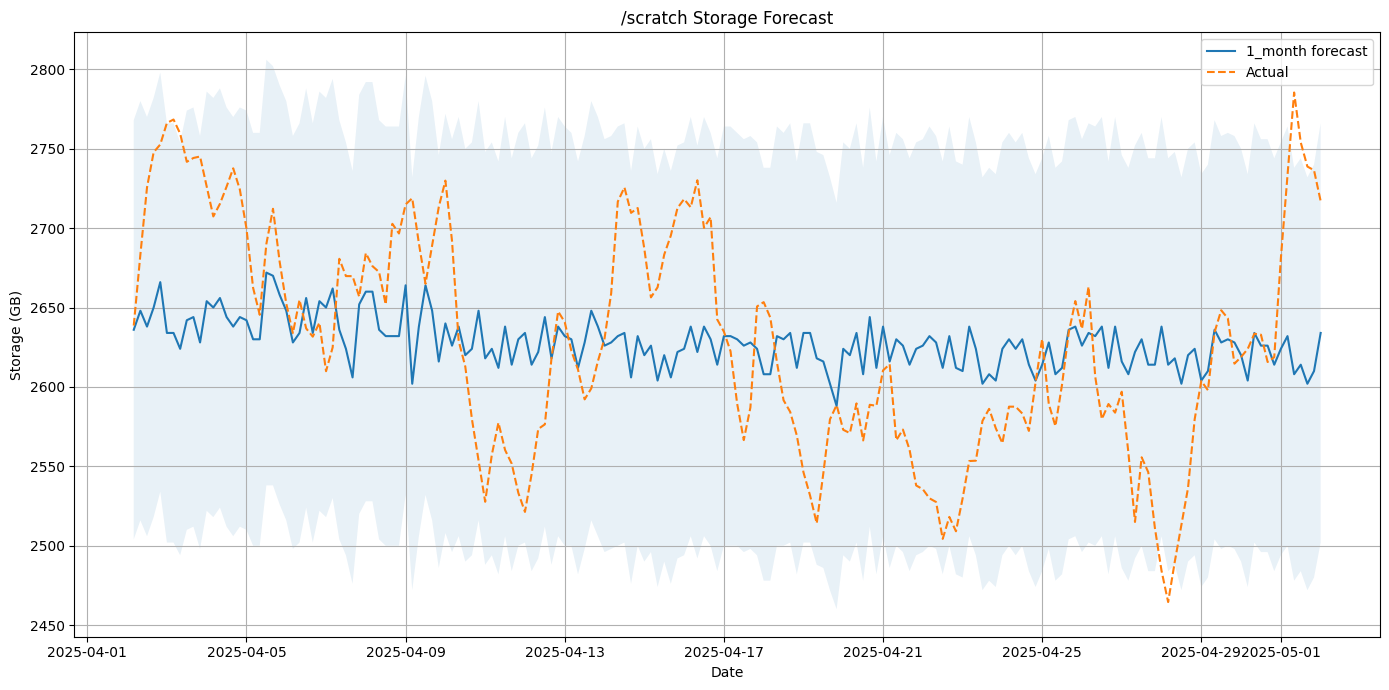


📊 /PROJECTS PERFORMANCE
1 Month      RMSE: 120.09 GB


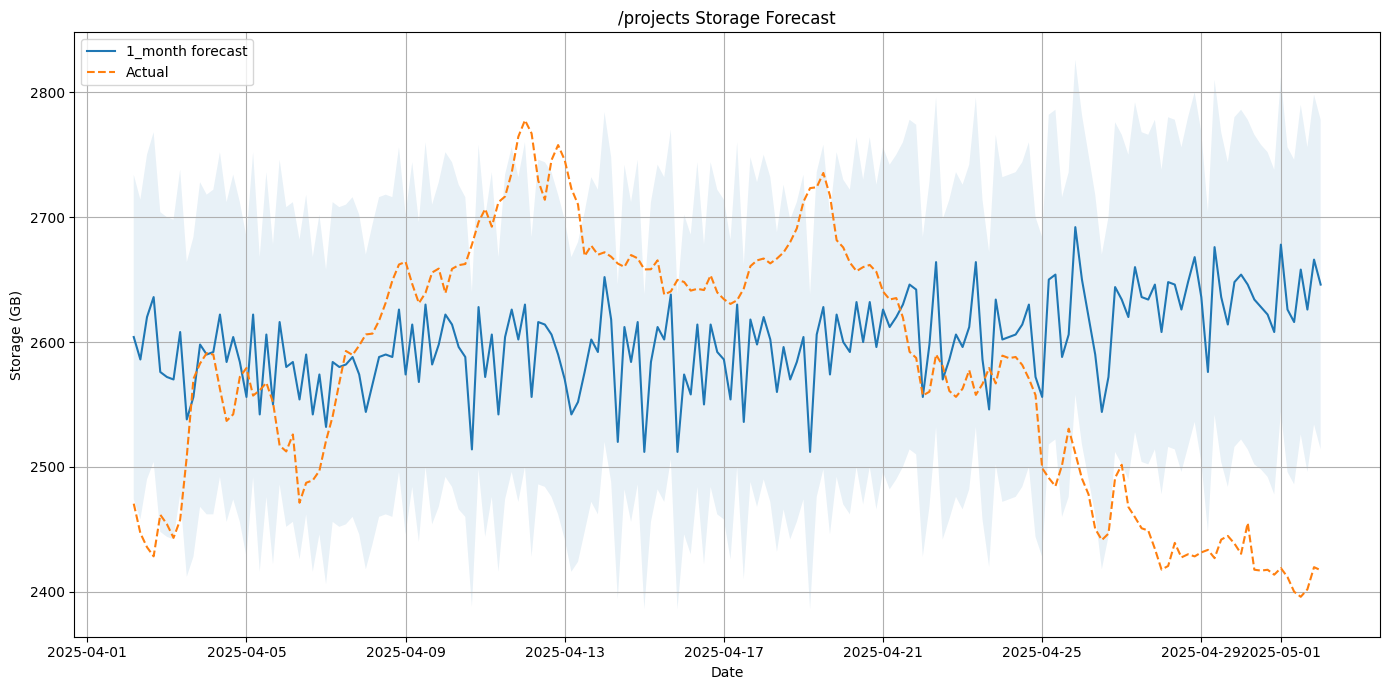


📊 /CUSTOMER PERFORMANCE
1 Month      RMSE: 47.81 GB


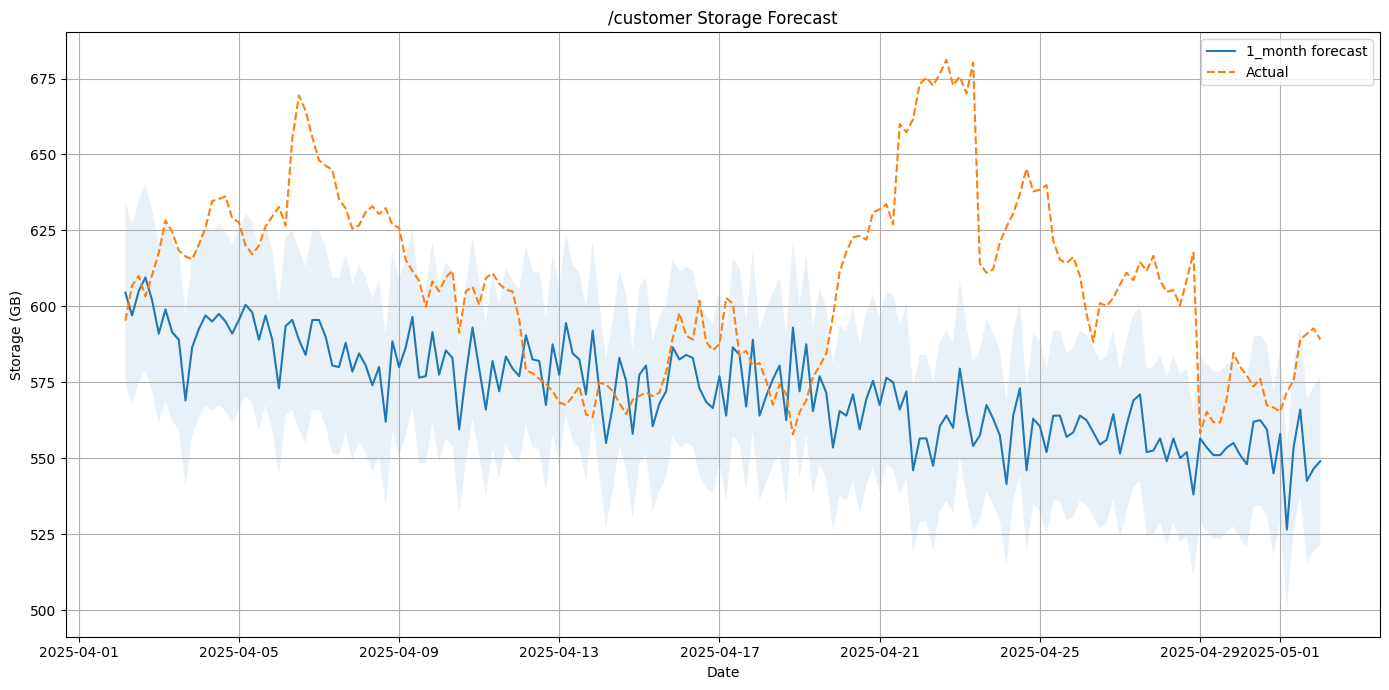


📊 /INFO PERFORMANCE
1 Month      RMSE: 34.51 GB


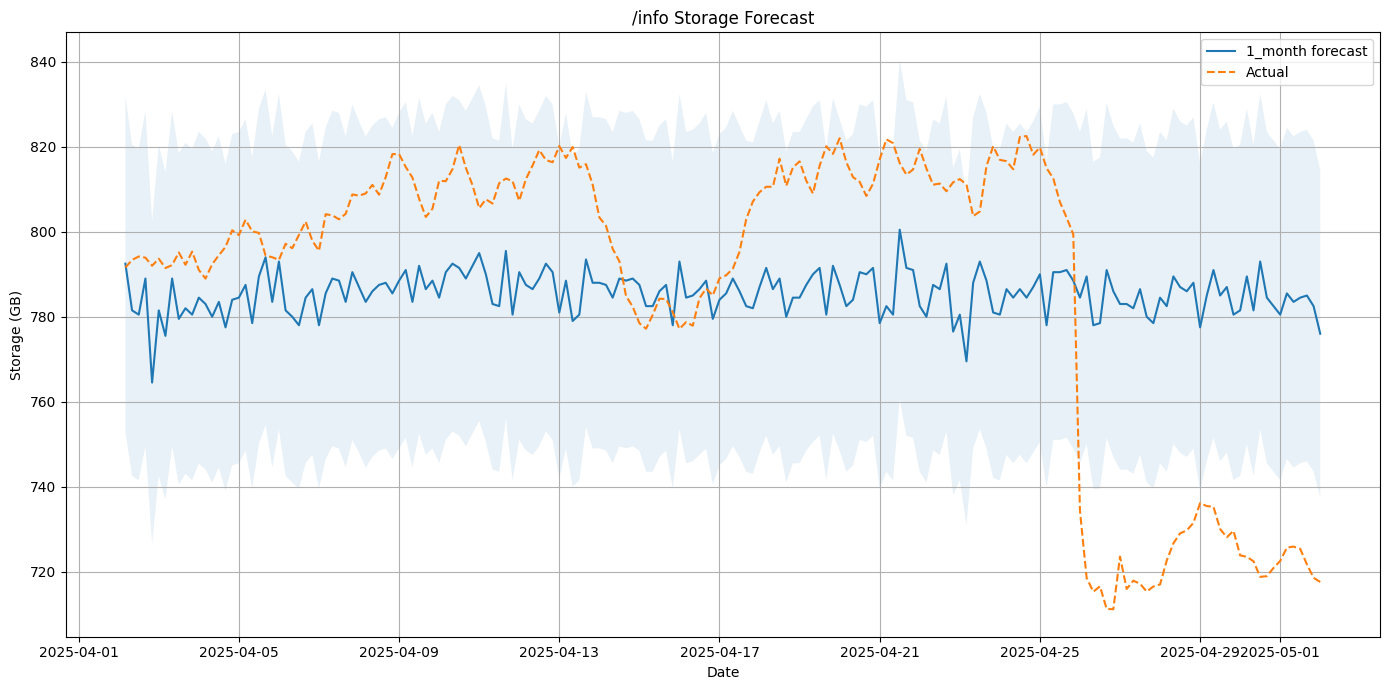

In [10]:

if __name__ == "__main__":
    data_dict = load_and_preprocess_data()
    models, metrics = train_and_evaluate(data_dict)

    for directory in data_dict:
        if directory in metrics:
            print(f"\n📊 {directory.upper()} PERFORMANCE")
            for horizon in HORIZONS:
                if horizon in metrics[directory]:
                    rmse = metrics[directory][horizon]['rmse']
                    print(f"{horizon.replace('_', ' ').title():<12} RMSE: {rmse:.2f} GB")
            plot_results(directory, data_dict[directory], metrics)